In [1]:
# ==============================================================================
# CELL 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional
import operator

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# Thư viện hỗ trợ
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True # Đặt là True để xem log chi tiết, False để chạy im lặng

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    """Hàm in một bước trong quy trình."""
    if VERBOSE_MODE:
        console.print(f"[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    """Hàm in kết quả (như JSON) một cách đẹp mắt."""
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)

# --- KHỞI TẠO LLM ---
try:
    llm = ChatGroq(
        temperature=0.1, model="llama3-70b-8192",
        api_key=os.getenv("GROQ_API_KEY"), max_tokens=2048
    )
    print("✅ LLM (Groq) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Lỗi: {e}")
    llm = None

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


✅ LLM (Groq) đã được khởi tạo thành công.


In [2]:
# ==============================================================================
# CELL 1.5: TẢI KHO TRI THỨC RAG ĐÃ XỬ LÝ SẴN
# ==============================================================================
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# --- CẤU HÌNH ---
VECTOR_STORE_PATH = "vector_store/sgk_toan_9"
EMBEDDING_MODEL = "all-MiniLM-L6-v2"

# --- HÀM TẢI KHO TRI THỨC ---
def load_vector_store():
    """Tải kho tri thức đã được xây dựng từ local."""
    if not os.path.exists(VECTOR_STORE_PATH):
        print(f"❌ LỖI: Không tìm thấy kho tri thức tại '{VECTOR_STORE_PATH}'.")
        print("Vui lòng chạy file 'build_knowledge_base.py' trước để tạo kho tri thức.")
        return None
    
    try:
        print(f"✅ Đang tải kho tri thức từ: {VECTOR_STORE_PATH}...")
        embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
        db = FAISS.load_local(VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True)
        print("🎉 Tải kho tri thức thành công!")
        return db
    except Exception as e:
        print(f"❌ LỖI khi tải kho tri thức: {e}")
        return None

# --- TẢI VÀ SỬ DỤNG ---
vector_store = load_vector_store()

✅ Đang tải kho tri thức từ: vector_store/sgk_toan_9...


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎉 Tải kho tri thức thành công!


In [3]:
# ==============================================================================
# CELL 2: ĐỊNH NGHĨA STATE CHO HỆ THỐNG (PHIÊN BẢN CUỐI CÙNG)
# ==============================================================================
from langgraph.graph.message import add_messages # <-- Import add_messages ở đây

# --- Hàm tiện ích ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Định nghĩa các cấu trúc dữ liệu con ---
class AnalyzedObjective(TypedDict):
    action_verb: str
    bloom_level: int
    topic: str
    grade_level: str
    constraints: List[str]

class PedagogyStrategy(TypedDict):
    chosen_pedagogy: str
    pedagogy_rationale: str
    suggested_structure: List[Dict[str, Any]]

class Task(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    status: Literal["pending", "completed"]

# --- Định nghĩa State chính (phiên bản hoàn chỉnh nhất) ---
class TeacherState(TypedDict):
    # Dùng add_messages là cách làm đúng chuẩn cho kênh messages
    messages: Annotated[List[BaseMessage], add_messages]
    
    analyzed_objective: Optional[AnalyzedObjective]
    pedagogy_strategy: Optional[PedagogyStrategy]
    task_list: Optional[List[Task]]
    current_task_id: Optional[int]
    
    # Dùng merge_dicts để các agent không ghi đè kết quả của nhau
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    
    final_lesson_plan: Optional[str]
    
    # Kênh này dùng để điều phối, không cần decorator đặc biệt
    next_agent: str

print("✅ 'TeacherState' (phiên bản cuối cùng) đã được định nghĩa.")

✅ 'TeacherState' (phiên bản cuối cùng) đã được định nghĩa.


In [30]:
# ==============================================================================
# CELL 3: XÂY DỰNG CÁC AGENT (PHIÊN BẢN SỬA LỖI CUỐI CÙNG)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional

# --- Các class định nghĩa cấu trúc (Giữ nguyên) ---
class ParsedObjective(BaseModel):
    action_verb: str = Field(description="Động từ hành động chính, ví dụ: 'phân tích', 'trình bày'.")
    bloom_level: int = Field(description="Cấp độ tư duy theo thang Bloom (1-6).")
    topic: str = Field(description="Chủ đề chính của bài học.")
    grade_level: str = Field(description="Cấp lớp của học sinh, ví dụ: 'Lớp 9'.")

class PedagogyChoice(BaseModel):
    chosen_pedagogy: str = Field(description="Tên phương pháp sư phạm được chọn.")
    pedagogy_rationale: str = Field(description="Lý do tại sao phương pháp này lại phù hợp.")

class TaskList(BaseModel):
    tasks: List[Dict[str, str]] = Field(description="Danh sách nhiệm vụ, mỗi nhiệm vụ có 'task_name' và 'task_description'.")

class TaskClassification(BaseModel):
    agent_category: Literal["activity_designer", "resource_scout", "assessment_creator", "unknown"] = Field(description="Loại agent nên thực hiện nhiệm vụ này.")

# --- Các agent tuần tự ban đầu ---

async def objective_interpreter_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` đang phân tích mục tiêu...")
    user_request = state['messages'][-1].content
    prompt = f"""Phân tích yêu cầu giáo dục sau để trích xuất mục tiêu học tập.
    - QUAN TRỌNG: Nếu có nhiều động từ, hãy chọn động từ ở cấp độ tư duy cao nhất (ví dụ: chọn 'vận dụng' thay vì 'hiểu').
    - THANG ĐO BLOOM: 1-Nhớ, 2-Hiểu, 3-Vận dụng, 4-Phân tích, 5-Đánh giá, 6-Sáng tạo.
    - YÊU CẦU: "{user_request}"

    Chỉ trả về một đối tượng JSON duy nhất theo định dạng sau:
    {{
      "action_verb": "động từ hành động",
      "bloom_level": "số nguyên cấp độ bloom",
      "topic": "chủ đề bài học",
      "grade_level": "cấp lớp"
    }}
    """
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    parsed_result = await structured_llm.ainvoke(prompt)
    analyzed_objective_dict = parsed_result.dict()
    analyzed_objective_dict["constraints"] = []
    print_result(analyzed_objective_dict, "Mục tiêu đã phân tích")
    return {"analyzed_objective": analyzed_objective_dict}

async def pedagogy_strategist_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("\n---\n### 🧑‍🏫 `Agent: Pedagogy Strategist` Bắt đầu...")
    objective = state['analyzed_objective']
    prompt = f"""Bạn là chuyên gia sư phạm. Dựa vào mục tiêu, hãy chọn một chiến lược dạy học phù hợp nhất từ các lựa chọn sau: Direct Instruction, Collaborative Learning, Inquiry-Based Learning (IBL), Hybrid Model.
    MỤC TIÊU: {objective}

    **YÊU CẦU QUAN TRỌNG:** Toàn bộ câu trả lời, bao gồm cả lý do, phải bằng Tiếng Việt.

    Chỉ trả về một đối tượng JSON hợp lệ có dạng:
    {{
      "chosen_pedagogy": "Tên phương pháp",
      "pedagogy_rationale": "Lý do chi tiết bằng Tiếng Việt"
    }}
    """
    response = await llm.with_structured_output(schema=PedagogyChoice, method="json_mode").ainvoke(prompt)
    pedagogy_strategy_dict = response.dict()
    pedagogy_strategy_dict["suggested_structure"] = []
    print_result(f"**Chiến lược:** {response.chosen_pedagogy}\n**Lý do:** {response.pedagogy_rationale}")
    return {"pedagogy_strategy": pedagogy_strategy_dict}

# --- SỬA LỖI ƯU TIÊN #1: Đảm bảo có nhiệm vụ đánh giá ---
async def plan_delegator_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("\n---\n### 👷 `Agent: Plan Delegator` Bắt đầu...")
    objective = state['analyzed_objective']
    strategy = state['pedagogy_strategy']
    prompt = f"""Bạn là quản lý dự án giáo dục. Dựa trên mục tiêu và chiến lược, chia nhỏ công việc tạo giáo án thành một danh sách các nhiệm vụ cụ thể.
    Mục tiêu: {objective['topic']} (Bloom: {objective['bloom_level']})
    Chiến lược: {strategy['chosen_pedagogy']}

    **YÊU CẦU BẮT BUỘC:**
    1.  Tạo một chuỗi các hoạt động dạy học logic theo đúng chiến lược đã chọn.
    2.  **PHẢI có ít nhất MỘT nhiệm vụ cuối cùng để "Tạo câu hỏi/bài tập đánh giá" hoặc "Soạn bài tập củng cố kiến thức".** Nhiệm vụ này phải rõ ràng để giao cho chuyên gia đánh giá.

    Trả lời bằng một đối tượng JSON duy nhất chứa một key là "tasks", giá trị là một danh sách các đối tượng JSON, mỗi đối tượng có "task_name" và "task_description".
    """
    structured_llm = llm.with_structured_output(TaskList, method="json_mode")
    task_list_result = await structured_llm.ainvoke(prompt)
    tasks_with_status = [{"task_id": i, "task_name": t['task_name'], "task_description": t['task_description'], "status": "pending"} for i, t in enumerate(task_list_result.tasks)]
    print_result(f"**Đã tạo {len(tasks_with_status)} nhiệm vụ.**")
    return {"task_list": tasks_with_status}

async def task_dispatcher_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` đang phân loại nhiệm vụ...")
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}
    task_description = task_to_run['task_description']
    prompt = f"""Phân loại nhiệm vụ sau vào agent phù hợp nhất: 'activity_designer', 'resource_scout', 'assessment_creator', hoặc 'unknown'.
    NHIỆM VỤ: "{task_description}"

    Trả lời bằng một đối tượng JSON duy nhất có dạng: {{"agent_category": "tên_agent"}}
    """
    structured_llm = llm.with_structured_output(TaskClassification, method="json_mode")
    classification_result = await structured_llm.ainvoke(prompt)
    next_agent = classification_result.agent_category
    if next_agent == "unknown":
        print_step(f"Không nhận ra nhiệm vụ. Bỏ qua.")
        return {"next_agent": "mark_task_complete"}
    print_step(f"Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

# ... (Hàm update_agent_outputs và class LearningActivity giữ nguyên) ...
def update_agent_outputs(state: TeacherState, key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Một cái tên hấp dẫn và rõ ràng cho hoạt động, ví dụ: 'Trạm kiến thức', 'Thí nghiệm vui'.")
    description: str = Field(description="Mô tả chi tiết các bước thực hiện hoạt động cho giáo viên và học sinh.")
    duration_minutes: int = Field(description="Thời gian dự kiến để hoàn thành hoạt động (tính bằng phút).")
    activity_type: str = Field(description="Loại hoạt động, ví dụ: 'Khởi động', 'Làm việc nhóm', 'Thực hành cá nhân', 'Thí nghiệm'.")
    

async def activity_designer_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Activity Designer` đang thiết kế hoạt động...")
    objective = state['analyzed_objective']
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    
    # Lấy thêm ngữ cảnh từ RAG
    resources_summary = json.dumps(state.get('agent_outputs', {}).get('resources', []), indent=2, ensure_ascii=False)

    if not task_to_run:
        return {}
        
    prompt = f"""Bạn là chuyên gia thiết kế hoạt động dạy học sáng tạo. Thiết kế một hoạt động **CỤ THỂ** và chi tiết dựa trên thông tin sau:
    - Mục tiêu bài học: Học sinh lớp {objective['grade_level']} có thể {objective['action_verb']} về chủ đề "{objective['topic']}".
    - Nhiệm vụ cụ thể cần thực hiện: {task_to_run['task_description']}
    - **Kiến thức nền tảng có sẵn (từ Sách giáo khoa):**
      ```json
      {resources_summary}
      ```

    **YÊU CẦU QUAN TRỌNG:**
    - Không mô tả chung chung. Hãy dùng "Kiến thức nền tảng" để tạo ra các bước thực hành cụ thể.
    - Ví dụ: Thay vì nói "học sinh tìm hiểu công thức", hãy nói "học sinh dùng thước kẻ và eke để vẽ tam giác vuông có cạnh 3cm, 4cm, sau đó đo cạnh huyền và kiểm chứng công thức Pytago a²+b²=c²".
    - Hãy tạo ra một hoạt động bằng Tiếng Việt.

    Chỉ trả về một đối tượng JSON duy nhất theo định dạng sau:
    {{
        "activity_name": "Tên hoạt động thật hấp dẫn và rõ ràng",
        "description": "Mô tả chi tiết CÁC BƯỚC thực hiện cho giáo viên và học sinh",
        "duration_minutes": 20,
        "activity_type": "Loại hoạt động (ví dụ: Thảo luận nhóm, Thực hành cặp đôi, Thí nghiệm)"
    }}
    """
    structured_llm = llm.with_structured_output(LearningActivity, method="json_mode")
    activity_result = await structured_llm.ainvoke(prompt)
    print_result(activity_result.dict(), "Hoạt động đã được thiết kế")
    return update_agent_outputs(state, "activities", activity_result.dict())


# ... (Hàm resource_scout_agent giữ nguyên) ...
async def resource_scout_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Resource Scout (RAG)` đang làm việc...")
    topic = state['analyzed_objective']['topic']
    if not vector_store:
        print_step("⚠️ Cảnh báo: Không có kho tri thức.")
        return update_agent_outputs(state, "resources", {"source": "Lỗi", "summary": "Không tìm thấy kho tri thức."})
    print_step(f"Thực hiện tìm kiếm RAG cho chủ đề: '{topic}'")
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    relevant_docs = retriever.invoke(topic)
    context = "\n\n---\n\n".join([doc.page_content for doc in relevant_docs])
    prompt = f"""Dựa vào các trích đoạn từ sách giáo khoa dưới đây, hãy tóm tắt các điểm kiến thức cốt lõi và các định nghĩa quan trọng về chủ đề '{topic}'. Trình bày kết quả một cách rõ ràng, súc tích, dưới dạng các gạch đầu dòng."""
    response = await llm.ainvoke(prompt)
    summary = response.content
    resource = {"source": "Sách giáo khoa Toán 9 (từ RAG)", "summary": summary}
    print_result(resource, "Tài liệu RAG đã tìm thấy và tóm tắt")
    return update_agent_outputs(state, "resources", resource)

class AssessmentItem(BaseModel):
    question: str = Field(description="Nội dung câu hỏi hoặc yêu cầu của bài tập.")
    question_type: str = Field(description="Loại câu hỏi, ví dụ: 'Trắc nghiệm', 'Tự luận ngắn', 'Bài tập vận dụng'.")
    options: Optional[List[str]] = Field(description="Các lựa chọn trả lời nếu là câu hỏi trắc nghiệm.")
    answer: str = Field(description="Đáp án hoặc gợi ý đáp án cho câu hỏi.")

async def assessment_creator_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Assessment Creator` đang tạo câu hỏi đánh giá...")
    objective = state['analyzed_objective']
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    
    if not task_to_run:
        return {}

    prompt = f"""Bạn là chuyên gia về kiểm tra và đánh giá. Tạo ra MỘT câu hỏi hoặc bài tập nhỏ để đánh giá mục tiêu dựa trên nhiệm vụ sau:
    - Nhiệm vụ: "{task_to_run['task_description']}"
    - Mục tiêu: Học sinh lớp {objective['grade_level']} có thể {objective['action_verb']} về chủ đề "{objective['topic']}".
    - Viết bằng Tiếng Việt.

    YÊU CẦU ĐỊNH DẠNG:
    Trả lời bằng một đối tượng JSON duy nhất. TUYỆT ĐỐI KHÔNG thêm bất kỳ ghi chú, giải thích hay văn bản thừa nào khác.

    {{
        "question": "Nội dung câu hỏi...",
        "question_type": "Loại câu hỏi (ví dụ: Trắc nghiệm, Tự luận ngắn, Bài tập vận dụng)",
        "options": ["Lựa chọn 1", "Lựa chọn 2"] (hoặc null nếu không phải trắc nghiệm),
        "answer": "Đáp án chi tiết..."
    }}
    """
    # SỬA LỖI TRỌNG TÂM: Đảm bảo options có thể là List[str] hoặc null
    structured_llm = llm.with_structured_output(AssessmentItem, method="json_mode")
    
    assessment_result = await structured_llm.ainvoke(prompt)
    print_result(assessment_result.dict(), "Câu hỏi đánh giá đã được tạo")
    return update_agent_outputs(state, "assessments", assessment_result.dict())

# ... (Hàm lesson_plan_compiler_agent giữ nguyên) ...
async def lesson_plan_compiler_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("`Agent: Lesson Plan Compiler` đang tổng hợp giáo án...")
    outputs = state['agent_outputs']
    objective = state['analyzed_objective']
    
    # Tính tổng thời gian
    activities = outputs.get('activities', [])
    total_duration = sum(act.get('duration_minutes', 0) for act in activities)

    prompt = f"""Bạn là một trợ lý giáo viên chuyên nghiệp. Nhiệm vụ của bạn là tổng hợp tất cả các thông tin dưới đây thành một giáo án hoàn chỉnh, chuyên nghiệp bằng Tiếng Việt, sử dụng định dạng Markdown.

    **THÔNG TIN ĐẦU VÀO:**
    - **Mục tiêu chính của bài học:** {objective['topic']}
    - **Các hoạt động đã được thiết kế:** {json.dumps(activities, indent=2, ensure_ascii=False)}
    - **Các tài nguyên tham khảo:** {json.dumps(outputs.get('resources', []), indent=2, ensure_ascii=False)}
    - **Các câu hỏi/bài tập đánh giá:** {json.dumps(outputs.get('assessments', []), indent=2, ensure_ascii=False)}

    **YÊU CẦU VỀ CẤU TRÚC VÀ NỘI DUNG:**
    1.  Tạo giáo án có cấu trúc rõ ràng: Mục tiêu, Chuẩn bị, Tiến trình (liệt kê chi tiết từng hoạt động), Đánh giá.
    2.  Trong phần "Tiến trình", hãy ghi rõ thời gian dự kiến cho từng hoạt động.
    3.  **Thêm một mục "Ghi chú của Trợ lý AI" ở cuối giáo án.** Trong mục này, hãy tính và ghi rõ tổng thời lượng của tất cả các hoạt động ({total_duration} phút). Nếu tổng thời lượng vượt quá 90 phút, hãy thêm một lời khuyên cho giáo viên về việc chia bài học thành nhiều buổi.
    """
    response = await llm.ainvoke(prompt)
    final_plan = response.content
    print_step("Đã biên soạn xong giáo án cuối cùng.")
    return {"final_lesson_plan": final_plan}

✅ Graph (phiên bản ổn định nhất) đã được biên dịch thành công.


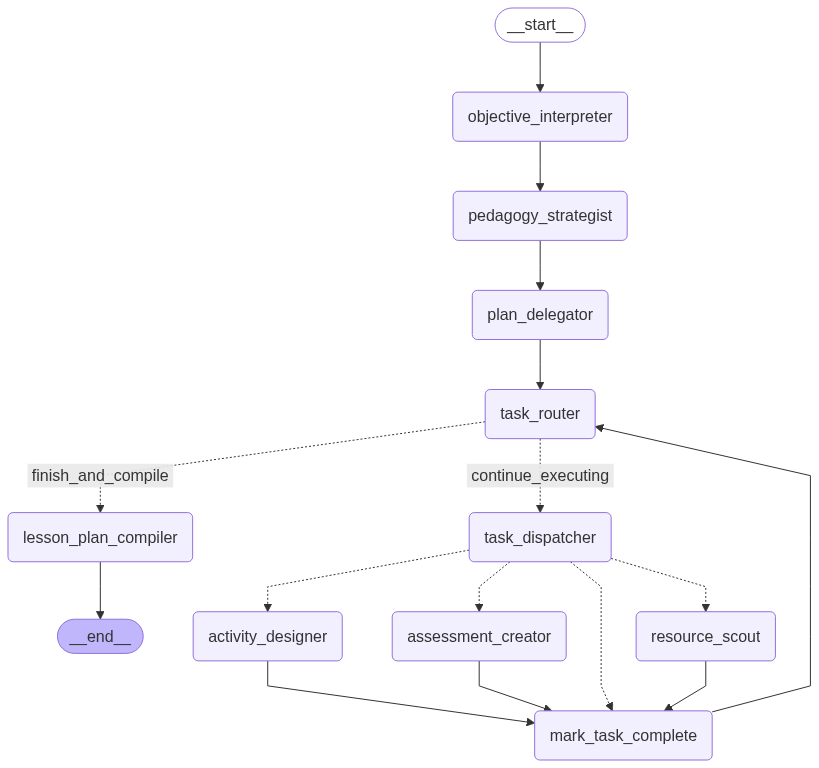

In [31]:
# ==============================================================================
# CELL 4: LẮP RÁP GRAPH (PHIÊN BẢN ỔN ĐỊNH NHẤT)
# ==============================================================================

# --- CÁC HÀM LOGIC VÀ NODE TIỆN ÍCH (Giữ nguyên) ---
def mark_task_complete(state: TeacherState) -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: TeacherState) -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    
    # Tìm nhiệm vụ đầu tiên còn ở trạng thái "pending"
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        # Nếu có, trả về ID của nó
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, báo hiệu để đi đến Compiler.")
        # Nếu không còn, trả về None để hàm điều hướng biết
        return {"current_task_id": None}

async def task_dispatcher_agent(state: TeacherState) -> Dict[str, Any]:
    print_step("\n---\n### 🚚 `Agent: Task Dispatcher` Bắt đầu...")
    current_task_id = state.get("current_task_id")
    task_list = state.get("task_list", [])
    task_to_run = next((task for task in task_list if task.get("task_id") == current_task_id), None)
    if not task_to_run: return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"""Phân loại nhiệm vụ sau vào agent phù hợp nhất: 'activity_designer', 'resource_scout', 'assessment_creator', hoặc 'unknown'.
    NHIỆM VỤ: "{task_description}" """
    structured_llm = llm.with_structured_output(TaskClassification)
    classification_result = await structured_llm.ainvoke(prompt)
    next_agent = classification_result.agent_category
    if next_agent == "unknown":
        print_step(f"--- 🚚 `Dispatcher`: Không nhận ra nhiệm vụ. Bỏ qua.")
        return {"next_agent": "mark_task_complete"}
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

# --- HÀM ĐỊNH TUYẾN CUỐI CÙNG (Cực kỳ đơn giản) ---
def route_after_router(state: TeacherState) -> Literal["continue_executing", "finish_and_compile"]:
    """
    Quyết định xem nên tiếp tục vòng lặp hay đi đến bước cuối.
    Logic: Nếu `task_router` không tìm thấy nhiệm vụ nào và trả về `current_task_id` là None,
    thì chúng ta sẽ kết thúc và biên soạn giáo án.
    """
    if state.get("current_task_id") is None:
        return "finish_and_compile"
    else:
        return "continue_executing"

# --- XÂY DỰNG GRAPH ---
workflow = StateGraph(TeacherState)

# Thêm các node
# ... (thêm tất cả các node như cũ) ...
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("resource_scout", resource_scout_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("lesson_plan_compiler", lesson_plan_compiler_agent)


# Kết nối
workflow.set_entry_point("objective_interpreter")
workflow.add_edge("objective_interpreter", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Điểm rẽ nhánh chính sau router
workflow.add_conditional_edges(
    "task_router",
    route_after_router, # Dùng hàm logic đơn giản này
    {
        "continue_executing": "task_dispatcher",
        "finish_and_compile": "lesson_plan_compiler"
    }
)

# Dispatcher quyết định đi đâu
workflow.add_conditional_edges(
    "task_dispatcher",
    lambda state: state["next_agent"],
    {
        "activity_designer": "activity_designer",
        "resource_scout": "resource_scout",
        "assessment_creator": "assessment_creator",
        "mark_task_complete": "mark_task_complete"
    }
)

# Vòng lặp
workflow.add_edge("activity_designer", "mark_task_complete")
workflow.add_edge("resource_scout", "mark_task_complete")
workflow.add_edge("assessment_creator", "mark_task_complete")
workflow.add_edge("mark_task_complete", "task_router")

# Kết thúc
workflow.add_edge("lesson_plan_compiler", END)

# Biên dịch
app = workflow.compile()
print("✅ Graph (phiên bản ổn định nhất) đã được biên dịch thành công.")

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}")

In [32]:
# ==============================================================================
# CELL 5: CHẠY THỬ NGHIỆM (PHIÊN BẢN LOG ĐẸP)
# ==============================================================================

async def run_graph(user_request: str):
    """
    Hàm để chạy graph với một yêu cầu cụ thể, theo dõi các bước,
    và in ra kết quả cuối cùng một cách đẹp mắt.
    """
    
    # Khởi tạo trạng thái ban đầu
    initial_state = {
        "messages": [HumanMessage(content=user_request)],
        "agent_outputs": {},
        "analyzed_objective": None, "pedagogy_strategy": None,
        "task_list": None, "current_task_id": None,
        "final_lesson_plan": None, "next_agent": ""
    }
    
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    
    config = {"recursion_limit": 50}
    final_state_result = None
    
    # astream sẽ trả về một stream các sự kiện của graph
    async for event in app.astream(initial_state, config=config):
        # Mỗi event là một dictionary chứa tên node và kết quả (state) sau khi node đó chạy
        for node_name, node_output in event.items():
            console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
            # Lưu lại state cuối cùng sau mỗi bước
            final_state_result = node_output

    console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH.[/bold magenta]")
    
    # In ra các thông tin quan trọng sau khi quy trình kết thúc
    if final_state_result:
        # In ra giáo án cuối cùng
        if final_state_result.get("final_lesson_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH[/bold green]")
            console.print(Markdown(final_state_result["final_lesson_plan"]))
        
        # In ra toàn bộ state cuối cùng để debug nếu cần
        if VERBOSE_MODE:
            console.print("\n[bold blue]🕵️‍♂️ TRẠNG THÁI CUỐI CÙNG (ĐỂ DEBUG)[/bold blue]")
            pprint(final_state_result)
    else:
        console.print("\n[bold red]⚠️ Không có kết quả cuối cùng để hiển thị.[/bold red]")


# --- KỊCH BẢN THỬ NGHIỆM MỚI CHO RAG ---
# Yêu cầu một chủ đề có trong sách giáo khoa Toán 9
request_rag_test = "Soạn giáo án cho học sinh lớp 9. Mục tiêu là giúp các em hiểu và vận dụng được các hệ thức lượng trong tam giác vuông trong 2 tiết học 45 phút trên trường"

# --- BẬT/TẮT LOG CHI TIẾT ---
# Đặt là True để xem log chi tiết của từng agent
# Đặt là False để chỉ xem các tiêu đề chính
VERBOSE_MODE = True 

# --- CHẠY THỬ ---
# Chạy graph với yêu cầu đã chuẩn bị
await run_graph(request_rag_test)

🚀 BẮT ĐẦU QUY TRÌNH VỚI YÊU CẦU:
> Soạn giáo án cho học sinh lớp 9. Mục tiêu là giúp các em hiểu và vận dụng được các hệ thức lượng trong tam giác 
vuông trong 2 tiết học 45 phút trên trường

> `Agent: Objective Interpreter` đang phân tích mục tiêu...

✔️ Mục tiêu đã phân tích:

{
│   'action_verb': 'vận dụng',
│   'bloom_level': 3,
│   'topic': 'hệ thức lượng trong tam giác vuông',
│   'grade_level': '9',
│   'constraints': []
}

------- Hoàn thành bước: objective_interpreter -------

> 
---
### 🧑‍🏫 `Agent: Pedagogy Strategist` Bắt đầu...

✔️ Kết quả:

'**Chiến lược:** Inquiry-Based Learning (IBL)\n**Lý do:** Với mục tiêu vận dụng hệ thức lượng trong tam giác vuông cho học sinh lớp 9, phương pháp Inquiry-Based Learning (IBL) là phù hợp nhất. Bởi vì, IBL cho phép học sinh tự khám phá và phát triển các khái niệm thông qua các hoạt động điều tra và giải quyết vấn đề, giúp học sinh vận dụng kiến thức đã học vào các tình huống thực tế. Ngoài ra, IBL cũng khuyến khích học sinh phát triển các kỹ năng như tư duy phê phán, giải quyết vấn đề và làm việc nhóm, đáp ứng yêu cầu của bậc 3 trong thang Bloom.'

------- Hoàn thành bước: pedagogy_strategist -------

> 
---
### 👷 `Agent: Plan Delegator` Bắt đầu...

✔️ Kết quả:

'**Đã tạo 5 nhiệm vụ.**'

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Introduction to Right Triangles' (ID: 0)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` đang thiết kế hoạt động...

✔️ Hoạt động đã được thiết kế:

{
│   'activity_name': 'Khám phá Tam Giác Vuông trong Đời Thực',
│   'description': 'Bước 1: Giáo viên giới thiệu khái niệm tam giác vuông và tầm quan trọng của nó trong các tình huống thực tế (5 phút). Bước 2: Học sinh chia thành cặp, mỗi cặp được cung cấp một thước kẻ và eke. Họ vẽ một tam giác vuông có cạnh 3cm, 4cm và đo cạnh huyền (5 phút). Bước 3: Học sinh tính toán và kiểm chứng công thức Pytago a²+b²=c² bằng cách đo và tính toán các cạnh của tam giác (5 phút). Bước 4: Học sinh chia sẻ kết quả và thảo luận về tầm quan trọng của tam giác vuông trong các ứng dụng thực tế (5 phút).',
│   'duration_minutes': 20,
│   'activity_type': 'Thực hành cặp đôi'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Exploration of Triangle Properties' (ID: 1)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` đang thiết kế hoạt động...

✔️ Hoạt động đã được thiết kế:

{
│   'activity_name': 'Khám phá bí mật của tam giác vuông',
│   'description': 'Bước 1: Học sinh chia thành cặp và nhận một tờ giấy có vẽ sẵn một tam giác vuông với cạnh 3cm và 4cm. Bước 2: Học sinh dùng thước kẻ và eke để vẽ thêm một cạnh huyền của tam giác vuông. Bước 3: Học sinh đo độ dài của cạnh huyền và ghi lại kết quả. Bước 4: Học sinh tính toán giá trị của a²+b² và so sánh với kết quả đo được ở bước 3. Bước 5: Học sinh thảo luận và chia sẻ kết quả với nhau, rút ra kết luận về hệ thức lượng trong tam giác vuông.',
│   'duration_minutes': 20,
│   'activity_type': 'Thực hành cặp đôi'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Investigation of Real-World Applications' (ID: 2)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` đang thiết kế hoạt động...

✔️ Hoạt động đã được thiết kế:

{
│   'activity_name': 'Áp dụng hệ thức lượng trong tam giác vuông vào thực tế',
│   'description': 'Bước 1: Học sinh chia thành nhóm 3-4 người và chọn một lĩnh vực ứng dụng của tam giác vuông (kiến trúc, vật lý, kỹ thuật). Bước 2: Học sinh vẽ một tam giác vuông có cạnh 5cm, 12cm và đo cạnh huyền bằng thước kẻ và eke. Bước 3: Học sinh áp dụng công thức Pytago (a²+b²=c²) để tính cạnh huyền và so sánh với kết quả đo được. Bước 4: Học sinh nghiên cứu và thu thập thông tin về ứng dụng của tam giác vuông trong lĩnh vực đã chọn. Bước 5: Học sinh trình bày kết quả nghiên cứu và ứng dụng của tam giác vuông trong lĩnh vực đã chọn.',
│   'duration_minutes': 40,
│   'activity_type': 'Thực hành nhóm'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Development of Problem-Solving Skills' (ID: 3)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` đang thiết kế hoạt động...

✔️ Hoạt động đã được thiết kế:

{
│   'activity_name': 'Khám phá Tam Giác Vuông với Công Thức Pytago',
│   'description': 'Bước 1: Học sinh chia thành cặp và nhận một tờ giấy có vẽ sẵn một tam giác vuông với cạnh 5cm và 12cm. Bước 2: Học sinh dùng thước kẻ và eke để vẽ thêm một cạnh huyền của tam giác vuông. Bước 3: Học sinh đo độ dài cạnh huyền và ghi lại kết quả. Bước 4: Học sinh tính toán giá trị của a² + b² và so sánh với kết quả đo được ở bước 3 để kiểm chứng công thức Pytago a² + b² = c². Bước 5: Học sinh trình bày kết quả và thảo luận với nhau về các trường hợp khác nhau của tam giác vuông.',
│   'duration_minutes': 20,
│   'activity_type': 'Thực hành cặp đôi'
}

------- Hoàn thành bước: activity_designer -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Create Assessment Questions/Bonus Exercises' (ID: 4)

------- Hoàn thành bước: task_router -------

> 
---
### 🚚 `Agent: Task Dispatcher` Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` đang tạo câu hỏi đánh giá...

✔️ Câu hỏi đánh giá đã được tạo:

{
│   'question': 'Trong tam giác vuông ABC, cạnh huyền là AB và cạnh góc vuông là AC = 5cm, BC = 12cm. Tính độ dài của cạnh AB.',
│   'question_type': 'Bài tập vận dụng',
│   'options': None,
│   'answer': 'Áp dụng hệ thức lượng trong tam giác vuông (định lý Pythagore): AB² = AC² + BC² => AB² = 5² + 12² => AB² = 25 + 144 => AB² = 169 => AB = √169 = 13cm.'
}

------- Hoàn thành bước: assessment_creator -------

------- Hoàn thành bước: mark_task_complete -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, báo hiệu để đi đến Compiler.

------- Hoàn thành bước: task_router -------

> `Agent: Lesson Plan Compiler` đang tổng hợp giáo án...

> Đã biên soạn xong giáo án cuối cùng.

------- Hoàn thành bước: lesson_plan_compiler -------

🏁 KẾT THÚC QUY TRÌNH.

📝 GIÁO ÁN HOÀN CHỈNH

Here is the complete lesson plan in Markdown format:                                                               

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                   Giáo Án: Hệ Thức Lượng trong Tam Giác Vuông                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                     Mục Tiêu                                                      

 • Học sinh hiểu và áp dụng hệ thức lượng trong tam giác vuông.                                                    
 • Học sinh phát triển kỹ năng tính toán và đo đạc trong tam giác vuông.                                           
 • Học sinh nhận thức được tầm quan trọng của tam giác vuông trong các ứng dụng thực tế.                           


                                                     Chuẩn Bị                                                      

 • Thước kẻ và eke cho mỗi cặp học sinh.                                                                           
 • Giấy vẽ tam giác vuông cho mỗi cặp học sinh.                                                                    
 • Tờ giấy có vẽ sẵn tam giác vuông cho mỗi cặp học sinh (hoạt động 2 và 4).                                       


                                                    Tiến Trình                                                     

                           Hoạt Động 1: Khám Phá Tam Giác Vuông trong Đời Thực (20 phút)                           

 • Bước 1: Giáo viên giới thiệu khái niệm tam giác vuông và tầm quan trọng của nó trong các tình huống thực tế (5  
   phút).                                                                                                          
 • Bước 2: Học sinh chia thành cặp, mỗi cặp được cung cấp một thước kẻ và eke. Họ vẽ một tam giác vuông có cạnh    
   3cm, 4cm và đo cạnh huyền (5 phút).                                                                             
 • Bước 3: Học sinh tính toán và kiểm chứng công thức Pytago a²+b²=c² bằng cách đo và tính toán các cạnh của tam   
   giác (5 phút).                                                                                                  
 • Bước 4: Học sinh chia sẻ kết quả và thảo luận về tầm quan trọng của tam giác vuông trong các ứng dụng thực tế (5
   phút).                                                                                                          

                             Hoạt Động 2: Khám Phá Bí Mật của Tam Giác Vuông (20 phút)                             

 • Bước 1: Học sinh chia thành cặp và nhận một tờ giấy có vẽ sẵn một tam giác vuông với cạnh 3cm và 4cm.           
 • Bước 2: Học sinh dùng thước kẻ và eke để vẽ thêm một cạnh huyền của tam giác vuông.                             
 • Bước 3: Học sinh đo độ dài của cạnh huyền và ghi lại kết quả.                                                   
 • Bước 4: Học sinh tính toán giá trị của a²+b² và so sánh với kết quả đo được ở bước 3.                           
 • Bước 5: Học sinh thảo luận và chia sẻ kết quả với nhau, rút ra kết luận về hệ thức lượng trong tam giác vuông.  

                   Hoạt Động 3: Áp Dụng Hệ Thức Lượng trong Tam Giác Vuông vào Thực Tế (40 phút)                   

 • Bước 1: Học sinh chia thành nhóm 3-4 người và chọn một lĩnh vực ứng dụng của tam giác vuông (kiến trúc, vật lý, 
   kỹ thuật).                                                                                                      
 • Bước 2: Học sinh vẽ một tam giác vuông có cạnh 5cm, 12cm và đo cạnh huyền bằng thước kẻ và eke.                 
 • Bước 3: Học sinh áp dụng công thức Pytago (a²+b²=c²) để tính cạnh huyền và so sánh với kết quả đo được.         
 • Bước 4: Học sinh nghiên cứu và thu thập thông tin về ứng dụng của tam giác vuông trong lĩnh vực đã chọn.        
 • Bước 5: Học sinh trình bày kết quả ngh

🕵️‍♂️ TRẠNG THÁI CUỐI CÙNG (ĐỂ DEBUG)

{
│   'final_lesson_plan': 'Here is the complete lesson plan in Markdown format:\n\n**Giáo Án: Hệ Thức Lượng trong Tam Giác Vuông**\n==============================================\n\n**Mục Tiêu**\n-----------\n\n* Học sinh hiểu và áp dụng hệ thức lượng trong tam giác vuông.\n* Học sinh phát triển kỹ năng tính toán và đo đạc trong tam giác vuông.\n* Học sinh nhận thức được tầm quan trọng của tam giác vuông trong các ứng dụng thực tế.\n\n**Chuẩn Bị**\n-------------\n\n* Thước kẻ và eke cho mỗi cặp học sinh.\n* Giấy vẽ tam giác vuông cho mỗi cặp học sinh.\n* Tờ giấy có vẽ sẵn tam giác vuông cho mỗi cặp học sinh (hoạt động 2 và 4).\n\n**Tiến Trình**\n--------------\n\n### Hoạt Động 1: Khám Phá Tam Giác Vuông trong Đời Thực (20 phút)\n\n* Bước 1: Giáo viên giới thiệu khái niệm tam giác vuông và tầm quan trọng của nó trong các tình huống thực tế (5 phút).\n* Bước 2: Học sinh chia thành cặp, mỗi cặp được cung cấp một thước kẻ và eke. Họ vẽ một tam giác vuông có cạnh 3cm, 4cm và đo cạnh huyền (5 phút).\n* Bước 3: Học sinh tính toán và kiểm chứng công thức Pytago a²+b²=c² bằng cách đo và tính toán các cạnh của tam giác (5 phút).\n* Bước 4: Học sinh chia sẻ kết quả và thảo luận về tầm quan trọng của tam giác vuông trong các ứng dụng thực tế (5 phút).\n\n### Hoạt Động 2: Khám Phá Bí Mật của Tam Giác Vuông (20 phút)\n\n* Bước 1: Học sinh chia thành cặp và nhận một tờ giấy có vẽ sẵn một tam giác vuông với cạnh 3cm và 4cm.\n* Bước 2: Học sinh dùng thước kẻ và eke để vẽ thêm một cạnh huyền của tam giác vuông.\n* Bước 3: Học sinh đo độ dài của cạnh huyền và ghi lại kết quả.\n* Bước 4: Học sinh tính toán giá trị của a²+b² và so sánh với kết quả đo được ở bước 3.\n* Bước 5: Học sinh thảo luận và chia sẻ kết quả với nhau, rút ra kết luận về hệ thức lượng trong tam giác vuông.\n\n### Hoạt Động 3: Áp Dụng Hệ Thức Lượng trong Tam Giác Vuông vào Thực Tế (40 phút)\n\n* Bước 1: Học sinh chia thành nhóm 3-4 người và chọn một lĩnh vực ứng dụng của tam giác vuông (kiến trúc, vật lý, kỹ thuật).\n* Bước 2: Học sinh vẽ một tam giác vuông có cạnh 5cm, 12cm và đo cạnh huyền bằng thước kẻ và eke.\n* Bước 3: Học sinh áp dụng công thức Pytago (a²+b²=c²) để tính cạnh huyền và so sánh với kết quả đo được.\n* Bước 4: Học sinh nghiên cứu và thu thập thông tin về ứng dụng của tam giác vuông trong lĩnh vực đã chọn.\n* Bước 5: Học sinh trình bày kết quả nghiên cứu và ứng dụng của tam giác vuông trong lĩnh vực đã chọn.\n\n### Hoạt Động 4: Khám Phá Tam Giác Vuông với Công Thức Pytago (20 phút)\n\n* Bước 1: Học sinh chia thành cặp và nhận một tờ giấy có vẽ sẵn một tam giác vuông với cạnh 5cm và 12cm.\n* Bước 2: Học sinh dùng thước kẻ và eke để vẽ thêm một cạnh huyền của tam giác vuông.\n* Bước 3: Học sinh đo độ dài cạnh huyền và ghi lại kết quả.\n* Bước 4: Học sinh tính toán giá trị của a² + b² và so sánh với kết quả đo được ở bước 3 để kiểm chứng công thức Pytago a² + b² = c².\n* Bước 5: Học sinh trình bày kết quả và thảo luận với nhau về các trường hợp khác nhau của tam giác vuông.\n\n**Đánh Giá**\n------------\n\n* Bài tập vận dụng: Trong tam giác vuông ABC, cạnh huyền là AB và cạnh góc vuông là AC = 5cm, BC = 12cm. Tính độ dài của cạnh AB.\n* Áp dụng hệ thức lượng trong tam giác vuông (định lý Pythagore): AB² = AC² + BC² => AB² = 5² + 12² => AB² = 25 + 144 => AB² = 169 => AB = √169 = 13cm.\n\n**Ghi chú của Trợ lý AI**\n-------------------------\n\n* Tổng thời lượng của tất cả các hoạt động: 100 phút.\n* Lời khuyên cho giáo viên: Nếu tổng thời lượng vượt quá 90 phút, hãy chia bài học thành nhiều buổi để học sinh có thể hấp thụ và thực hành đầy đủ.'
}